In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

In [3]:
df["category_name"] = df["product_category_tree"].str.split(r">>", regex=False, expand=True)[0]
df["category_name"] = df["category_name"].str.replace('["', '')
df = df[['description', 'category_name']].dropna(subset=['description', 'category_name'])

In [4]:
df['category_name'].value_counts()

,count
category_name,
Home Furnishing,150
Baby Care,150
Watches,150
Home Decor & Festive Needs,150
Kitchen & Dining,150
Beauty and Personal Care,150
Computers,150


In [5]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
from sklearn.ensemble import RandomForestClassifier

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy().squeeze()

# Encoder toutes les descriptions
df['description_vector'] = df['description'].apply(encode_text)

# Préparer les données d'entraînement et les étiquettes
X = np.vstack(df['description_vector'].values)
y = df['category_name']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


RandomForestClassifier(random_state=42)

Précision du modèle sur les données de test : 0.88
                                           description  \
20   Skmei AD1057-Dark-Orange Sports Analog-Digital...   
873  MSenterprises Floral Cushions Cover (Pack of 5...   
400  Buy TP-LINK TD-W8970 only for Rs. 5050 from Fl...   
168  Printland PMR1464 Ceramic Mug (350 g)\r\n     ...   
156  Printland PMBA1872 Ceramic Mug (350 ml)\r\n   ...   
789  Buy Love Baby Cartoon Set of Towels at Rs. 425...   
957  Key Features of Nutcase Multicolor Column Floo...   
468  Key Features of Tks Cotton Hair Towel Size: Me...   
457  Buy SRP Linen Cotton Plain King sized Double B...   
265  Lal Haveli Rajasthani Handmade Vintage Wooden ...   

                   category_name             category_predict  
20                      Watches                      Watches   
873             Home Furnishing              Home Furnishing   
400                   Computers                    Computers   
168            Kitchen & Dining             Kitchen & 

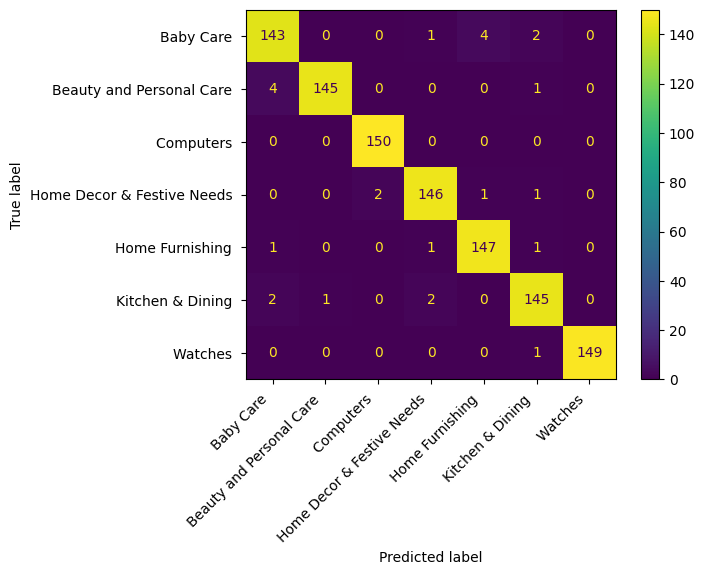

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Faire des prédictions et évaluer le modèle
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle sur les données de test : {accuracy:.2f}")

# Prédire les catégories sur l'ensemble du dataset
df['category_predict'] = clf.predict(np.vstack(df['description_vector'].values))

# Afficher un échantillon de prédictions pour vérifier
print(df[['description', 'category_name', 'category_predict']].sample(10))

# Calculer la précision globale et afficher les erreurs
accuracy = (df['category_name'] == df['category_predict']).mean()
print(f"Précision globale du modèle : {accuracy:.2f}")

# Afficher les erreurs
errors = df[df['category_name'] != df['category_predict']]
print("Nombre d'erreurs :", len(errors))
print(errors[['description', 'category_name', 'category_predict']].head(10))

# Rapport de classification
print(classification_report(df['category_name'], df['category_predict']))

# Afficher la matrice de confusion avec les étiquettes inclinées
disp = ConfusionMatrixDisplay.from_predictions(df['category_name'], df['category_predict'])
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**IMAGE CLASSIFICATION**

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Charger les données depuis le CSV
data_path = '/content/drive/MyDrive/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
data = pd.read_csv(data_path)

# Extraire les chemins d'images et les catégories
data['image_path'] = '/content/drive/MyDrive/Flipkart/Images/' + data['image']
data['category'] = data['product_category_tree'].apply(lambda x: eval(x)[0].split(" >> ")[0])
data["category"] = data["category"].str.replace('["', '')

# Paramètres de l'image et du modèle
img_height, img_width = 224, 224
batch_size = 16

# Préparation des données avec des augmentations d'images
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Générateur pour l'entraînement et la validation
train_generator = datagen.flow_from_dataframe(
    data,
    x_col='image_path',
    y_col='category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    data,
    x_col='image_path',
    y_col='category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Charger MobileNetV3
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Garder les couches de MobileNetV3 gelées pour l'apprentissage par transfert

# Construire le modèle
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Calcul des poids de classe
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Callback pour le taux d'apprentissage
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraîner le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights,
    callbacks=[lr_reduction]  # Ajouter le callback
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/52 ━━━━━━━━━━━━━━━━━━━━ 1:38 6s/step - accuracy: 0.1663 - loss: 3.7870

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 417s 7s/step - accuracy: 0.1616 - loss: 3.6122 - val_accuracy: 0.0913 - val_loss: 2.5187 - learning_rate: 0.0010
Epoch 2/10
 1/52 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0625 - loss: 2.3824

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.0625 - loss: 2.3824 - val_accuracy: 0.0000e+00 - val_loss: 2.5527 - learning_rate: 0.0010
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 54s 469ms/step - accuracy: 0.1480 - loss: 2.3824 - val_accuracy: 0.1346 - val_loss: 2.1975 - learning_rate: 0.0010
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0625 - loss: 2.0805 - val_accuracy: 0.0000e+00 - val_loss: 2.1873 - learning_rate: 0.0010
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 472ms/step - accuracy: 0.1545 - loss: 2.1478 - val_accuracy: 0.0913 - val_loss: 2.2923 - learning_rate: 0.0010
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.1250 - loss: 1.9441 - val_accuracy: 0.0000e+00 - val_loss: 2.3853 - learning_rate: 0.0010
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 480ms/step - accuracy: 0.1236 - loss: 2.1343 - val_accuracy: 0.3942 - val_loss: 1.9579 - learning_rate: 0.0010
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.0000e+00 - loss: 1.959

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 383ms/step - accuracy: 0.0261 - loss: 5.5438
Précision sur les données de validation : 0.04
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 590ms/step
                            precision    recall  f1-score   support

                 Baby Care       0.00      0.00      0.00        19
  Beauty and Personal Care       0.00      0.00      0.00        18
                 Computers       0.04      1.00      0.08         9
Home Decor & Festive Needs       0.00      0.00      0.00        34
           Home Furnishing       0.00      0.00      0.00        19
          Kitchen & Dining       0.00      0.00      0.00        83
                   Watches       0.00      0.00      0.00        28

                  accuracy                           0.04       210
                 macro avg       0.01      0.14      0.01       210
              weighted avg       0.00      0.04      0.00       210



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


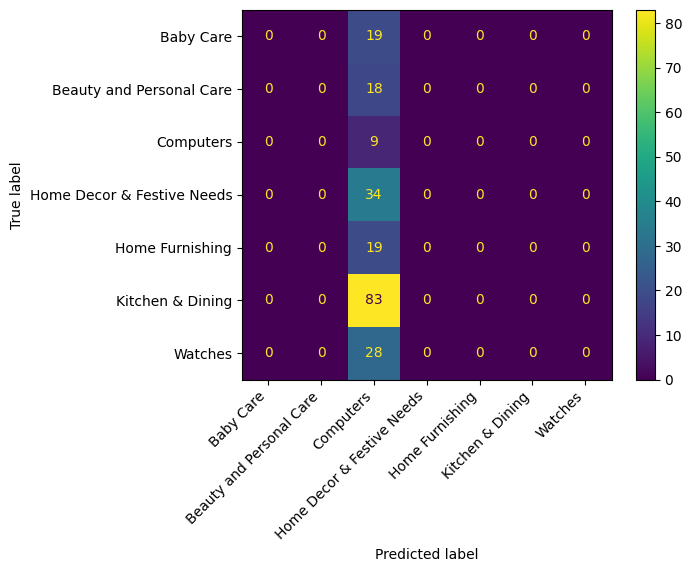

In [9]:
# Évaluation du modèle
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Précision sur les données de validation : {val_accuracy:.2f}")

# Prédictions et analyse
y_pred_proba = model.predict(validation_generator)
y_pred_classes = y_pred_proba.argmax(axis=1)

class_labels = list(train_generator.class_indices.keys())
y_true = validation_generator.classes

# Rapport de classification
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Matrice de confusion
disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes, display_labels=class_labels)
plt.xticks(rotation=45, ha='right')
plt.show()

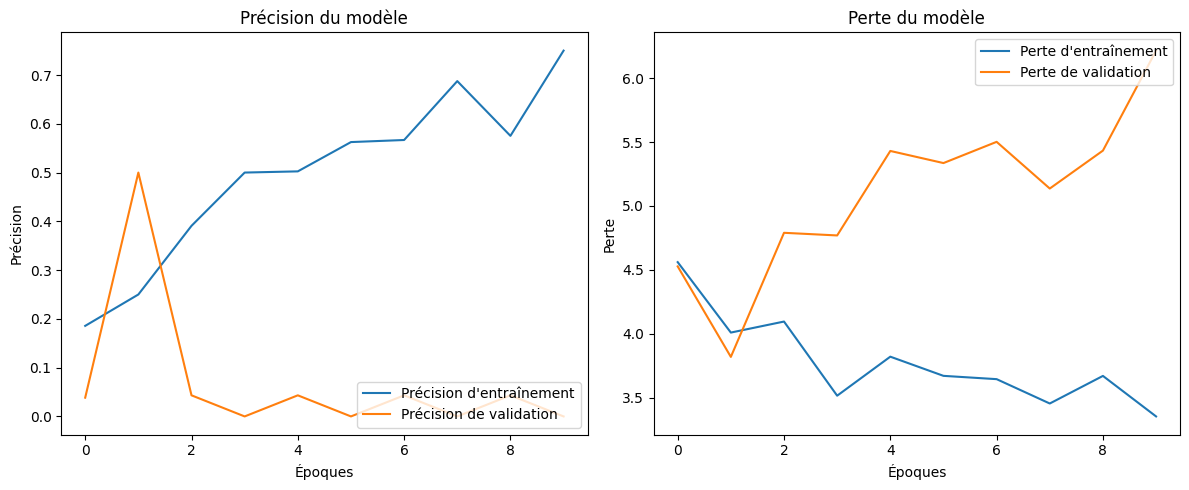

In [10]:
import matplotlib.pyplot as plt

# Tracer la précision
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Précision de validation')
plt.title('Précision du modèle')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend(loc='lower right')

# Tracer la perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Perte du modèle')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,648,656 (181.77 MB)

 Trainable params: 23,797,767 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 23,797,769 (90.78 MB)

In [18]:
from tensorflow.keras.layers import Input, Concatenate, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Fusion des sorties image et texte
combined = Concatenate()([image_output, text_output])
combined_output = Dense(64, activation='relu')(combined)
combined_output = Dropout(0.3)(combined_output)
final_output = Dense(len(train_generator.class_indices), activation='softmax')(combined_output)

# Modèle multi-input final
final_model = Model(inputs=[resnet_base.input, text_input], outputs=final_output)

# Compilation du modèle
final_model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Entraînement du modèle avec les générateurs et les données textuelles
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

final_model.fit(
    [train_generator, text_features],
    validation_data=(validation_generator, X_test_text),
    epochs=10,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=class_weights
)

NameError: name 'y_train_text' is not defined

**Multi inputs, combinaison des deux modèles**

In [14]:
from sklearn.preprocessing import LabelEncoder

# Création du modèle combiné
text_model_output = tf.keras.layers.Input(shape=(768,), name='text_input')  # La taille du vecteur de DistilBERT est 768
image_model_output = tf.keras.layers.Input(shape=(img_height[0], img_width[1], 3), name='image_input')

# Passer l'entrée d'image à EfficientNet
base_output = base_model(image_model_output)

# Aplatir la sortie d'EfficientNet
base_output_flat = layers.Flatten()(base_output)

# Fusion des sorties
x_combined = layers.Concatenate()([text_model_output, base_output_flat])

# Ajout de couches supplémentaires pour le modèle de fusion
x_combined = layers.Dense(128, activation='relu')(x_combined)
x_combined = layers.Dropout(0.2)(x_combined)
final_output = layers.Dense(train_dataset.cardinality().numpy(), activation='softmax')(x_combined)  # Nombre de classes

# Construction du modèle combiné
combined_model = Model(inputs=[text_model_output, image_model_output], outputs=final_output)

# Compilation du modèle combiné
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Préparer les données d'entraînement et de validation en tant que tableaux NumPy
X_image_train = np.concatenate([x.numpy() for x, _ in train_dataset])
y_image_train = np.concatenate([y.numpy() for _, y in train_dataset])

X_image_val = np.concatenate([x.numpy() for x, _ in validation_dataset])
y_image_val = np.concatenate([y.numpy() for _, y in validation_dataset])

# Encoder les étiquettes
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Entraîner le modèle combiné
combined_model.fit(
    [X_train, X_image_train],  # Entrées : vecteurs de texte et tableaux d'images
    y_train_encoded,  # Utiliser les étiquettes encodées
    validation_data=([X_test, X_image_val], y_test_encoded),  # Validation avec les données de validation
    epochs=10  # Vous pouvez ajuster le nombre d'époques
)


TypeError: 'int' object is not subscriptable

In [ ]:
# Évaluation du modèle sur l'ensemble de test
test_loss, test_accuracy = combined_model.evaluate([X_test, X_image_val], y_test_encoded)

print(f'Perte sur l\'ensemble de test : {test_loss:.4f}')
print(f'Précision sur l\'ensemble de test : {test_accuracy:.4f}')


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédire les étiquettes pour l'ensemble de test
y_pred = combined_model.predict([X_test, X_image_val])
y_pred_classes = np.argmax(y_pred, axis=1)

# Créer une matrice de confusion
cm = confusion_matrix(y_test_encoded, y_pred_classes)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification
report = classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_)
print(report)
